In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from Preprocessing.preprocessing_mne import get_raw_subject_data

In [2]:
def reshape_epochs_with_indices(epochs, n_epochs_to_include):
    """
    Truncate the epochs to a given number, reshape their time samples,
    and also return an index array that labels each time sample with the
    original epoch index.
    """
    # Get epoch data: shape (n_epochs, n_channels, n_epoch_size)
    epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    # Reshape to (n_epochs*n_epoch_size, n_channels)
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size).T
    # Create an index array indicating the original epoch number for each sample
    orig_indices = np.repeat(epochs.selection[:n_epochs_to_include], n_epoch_size)
    return epoch_data_reshaped, orig_indices

Reading 0 ... 23120  =      0.000 ...  2959.360 secs...
Boundaries: [0, 4082, 8164, 12246]


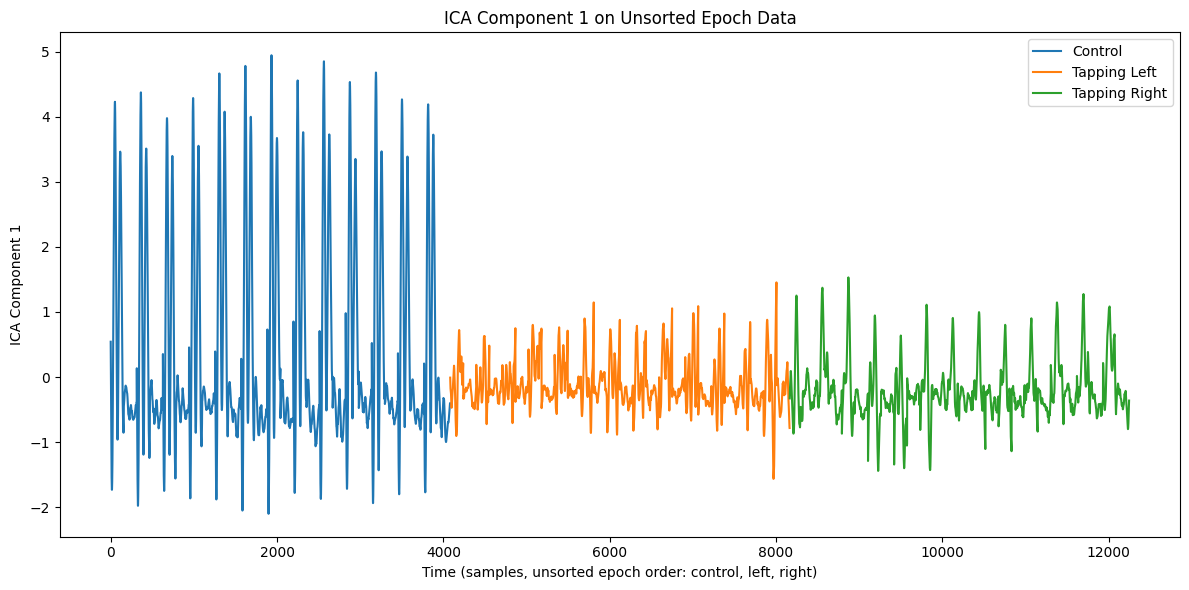

In [3]:
# --- Get raw epochs and reshape them with indices (as before)
epochs = get_raw_subject_data(subject=3)

control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# Concatenate in the original order: control, tapping left, tapping right
X = np.concatenate([control_data, left_data, right_data], axis=0)
# Here the class labels come in order naturally:
y = np.concatenate([np.full(control_data.shape[0], 1),
                    np.full(left_data.shape[0], 2),
                    np.full(right_data.shape[0], 3)])

# --- Pass the data into ICA WITHOUT any reordering --------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ica.fit_transform(X_scaled)
y_unsorted = y  # the order is as originally concatenated

# --- Now define the boundaries corresponding to each condition ----------
n_control = control_data.shape[0]
n_left = left_data.shape[0]
n_right = right_data.shape[0]
# Boundaries along the time axis (each epoch chunk is contiguous)
boundaries = [0, n_control, n_control + n_left, n_control + n_left + n_right]
print("Boundaries:", boundaries)

# --- Plot the ICA time series for Component 1 using the unsorted data ---
plt.figure(figsize=(12, 6))
colors = {1: "C0", 2: "C1", 3: "C2"}

# Plot control block
plt.plot(np.arange(boundaries[0], boundaries[1]),
         X_ica[boundaries[0]:boundaries[1], 0],
         color=colors[1], label="Control")

# Plot tapping left block
plt.plot(np.arange(boundaries[1], boundaries[2]),
         X_ica[boundaries[1]:boundaries[2], 0],
         color=colors[2], label="Tapping Left")

# Plot tapping right block
plt.plot(np.arange(boundaries[2], boundaries[3]),
         X_ica[boundaries[2]:boundaries[3], 0],
         color=colors[3], label="Tapping Right")

plt.xlabel("Time (samples, unsorted epoch order: control, left, right)")
plt.ylabel("ICA Component 1")
plt.title("ICA Component 1 on Unsorted Epoch Data")
plt.legend()
plt.tight_layout()
plt.show()

## Getting more clusters when including tapping data

We define a control preiod before the tapping command is given. Then define a tapping period after. Pass this data into the ICA, run a sliding window average power computation (skipping the overlap between different epochs) and checking for clusters.

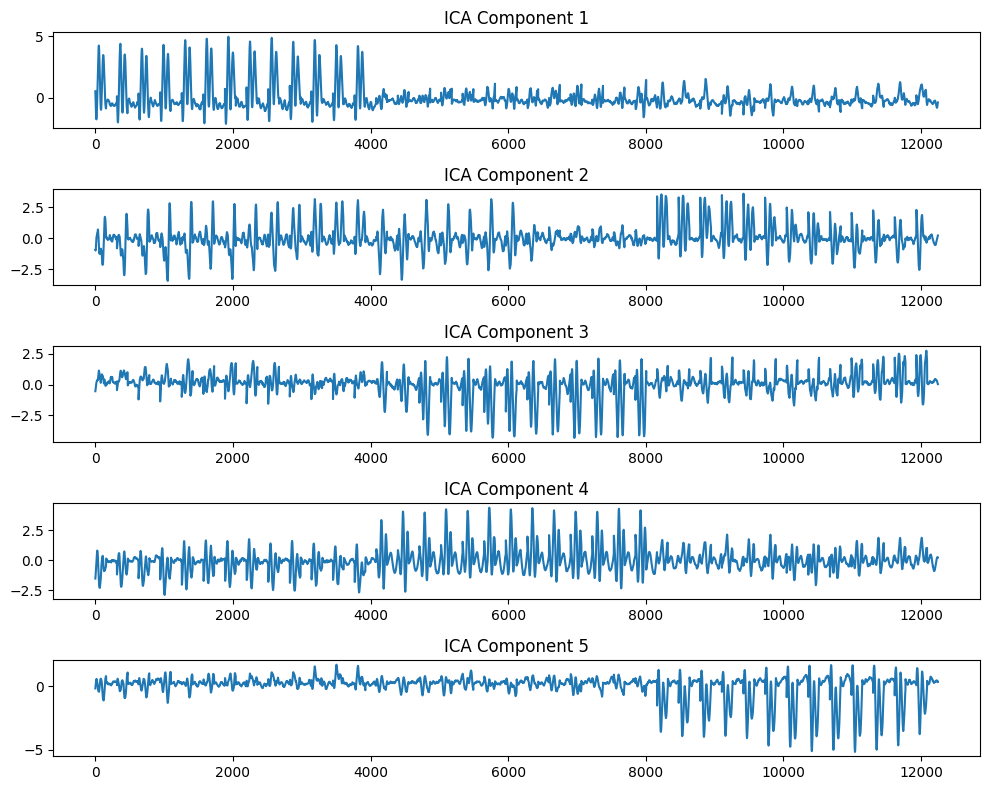

In [4]:
plt.figure(figsize=(10, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    plt.title(f'ICA Component {i + 1}')
plt.tight_layout()
plt.show()

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


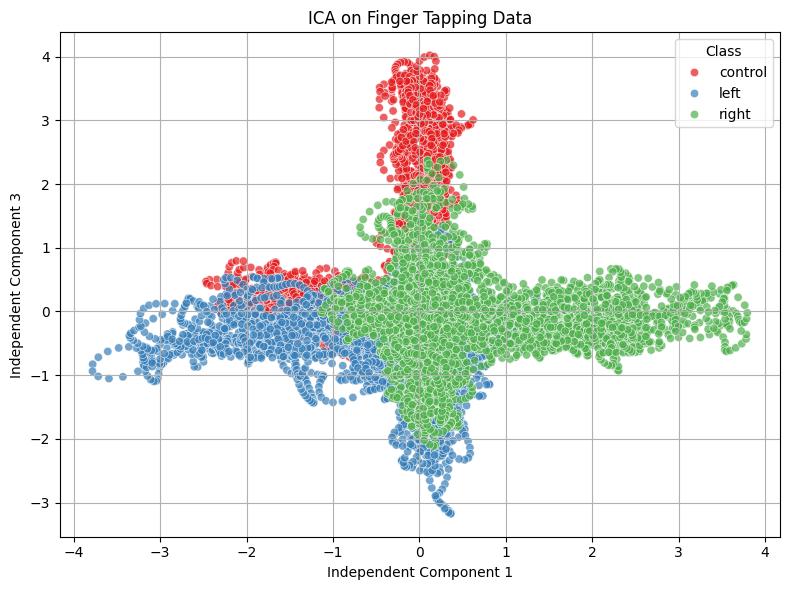

{'loc': array([-3.96163967e-02,  4.50141458e-02,  1.22816211e-01, -4.16132047e-02,
        2.67997753e-02,  1.29904394e-01, -3.76195887e-02,  6.32285163e-02,
        1.15728028e-01,  7.60000000e+02,             nan,             nan]), 'unit_mul': 0 (FIFF_UNITM_NONE), 'range': 1.0, 'cal': 1.0, 'kind': 1100 (FIFFV_FNIRS_CH), 'coil_type': 300 (FIFFV_COIL_FNIRS_HBO), 'unit': 6 (FIFF_UNIT_MOL), 'coord_frame': 4, 'ch_name': 'S1_D1 hbo', 'scanno': 1, 'logno': 1}


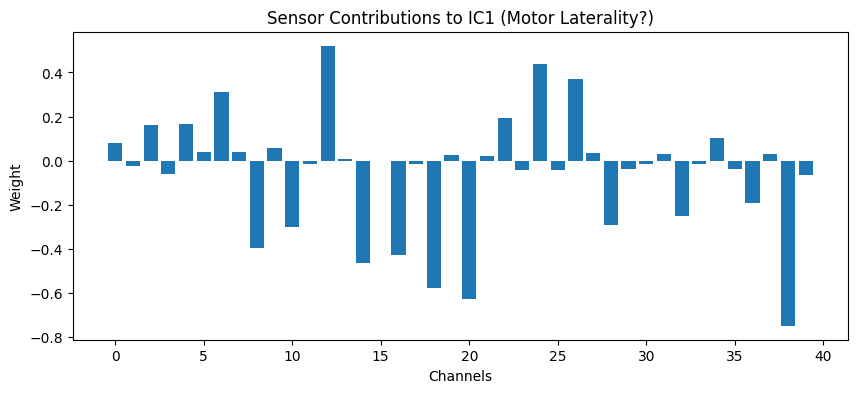

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load data
# subject = simple_pipeline(subject="01")
subject = get_raw_subject_data(subject=0)
subject_data = subject.get_data()
y = subject.events[:, -1]

# Divide each activity
control = subject['Control']
left = subject['Tapping_Left']
right = subject['Tapping_Right']

# Find the activity with min amount of epochs
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# Reshape function
def reshape_activity(epoch, min_bound):
    """Limit epochs to min bound, reshape data to channels x merged_epochs"""
    epoch_data = epoch.get_data()[:min_bound, :, :]
    # epoch_data = epoch.get_data()
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size)
    return epoch_data_reshaped.T

# Reshape all activities
control_reshaped = reshape_activity(control, min_bound)
left_reshaped = reshape_activity(left, min_bound)
right_reshaped = reshape_activity(right, min_bound)

# Define input matrix
X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

# Create labels
length = control_reshaped.shape[0]
y = np.concatenate([np.full(length, 1), np.full(length, 2), np.full(length, 3)])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X

# Apply ICA
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ica.fit_transform(X_scaled)

# Prepare DataFrame
ica_df = pd.DataFrame(X_ica)
ica_df['label'] = y

# Label mapping
def set_label_name(x):
    if x == 1: return 'control'
    elif x == 2: return 'left'
    elif x == 3: return 'right'
    else: return np.nan

ica_df['label_name'] = ica_df['label'].apply(set_label_name)

# Select components to plot
ic_x = 0  # First component
ic_y = 2  # Second component

# Plot ICA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ica_df, x=ic_x, y=ic_y, hue='label_name', alpha=0.7, palette="Set1")
plt.xlabel(f'Independent Component {ic_x + 1}')
plt.ylabel(f'Independent Component {ic_y + 1}')
plt.title('ICA on Finger Tapping Data')
plt.legend(title="Class")
plt.grid()
plt.tight_layout()
plt.show()

# Plot ICA component weights
print(subject.info['chs'][0])
plt.figure(figsize=(10, 4))
plt.bar(range(ica.mixing_.shape[0]), ica.mixing_[:, 0])
plt.title('Sensor Contributions to IC1 (Motor Laterality?)')
plt.xlabel('Channels')
plt.ylabel('Weight')
plt.show()


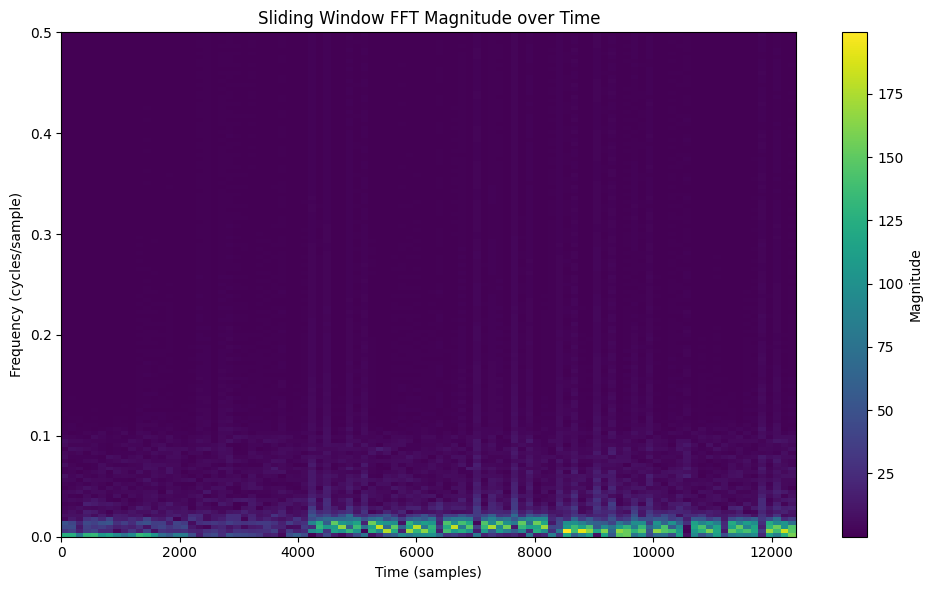

In [6]:
# Select the first channel from X as the signal for FFT analysis
signal = X_ica[:, 1]

# Define window and step sizes
win_size = 256      # window length (number of samples)
step_size = 128     # sliding step

# Calculate the number of windows
num_windows = (len(signal) - win_size) // step_size + 1

# Pre-allocate the spectrogram array (only non-negative frequencies are returned)
spectrogram = np.zeros((num_windows, win_size // 2 + 1))

# Compute FFT for each window and store the magnitude spectrum
for i in range(num_windows):
    start = i * step_size
    window_data = signal[start:start + win_size]
    fft_result = np.fft.rfft(window_data)
    spectrogram[i, :] = np.abs(fft_result)

# Frequency axis for FFT (in cycles per sample)
freqs = np.fft.rfftfreq(win_size, d=1)

# Time axis: here we use the starting index of each window as the time marker
times = np.arange(num_windows) * step_size

# Plot the spectrogram as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=(times[0], times[-1], freqs[0], freqs[-1]))
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (cycles/sample)')
plt.title('Sliding Window FFT Magnitude over Time')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

In [7]:
epochs = [
    [
        ["000", "001", "002", "003", "004"],
        ["010", "011", "012", "013", "014"],
        ["020", "021", "022", "023", "024"],
        ["030", "031", "032", "033", "034"],
    ],
    [
        ["100", "101", "102", "103", "104"],
        ["110", "111", "112", "113", "114"],
        ["120", "121", "122", "123", "124"],
        ["130", "131", "132", "133", "134"],
    ],
    [
        ["200", "201", "202", "203", "204"],
        ["210", "211", "212", "213", "214"],
        ["220", "221", "222", "223", "224"],
        ["230", "231", "232", "233", "234"],
    ]
]

epochs_np = np.array(epochs)
n_epoch, n_channels, n_epoch_size = epochs_np.shape
epoch_data_reshaped = epochs_np.reshape(n_channels, n_epoch * n_epoch_size).T
print(epoch_data_reshaped)
print("Shape of reshaped data:", epoch_data_reshaped.shape)

epoch_data_reshaped2 = epochs_np.swapaxes(1,2).reshape(n_epoch*n_epoch_size, n_channels)
print(epoch_data_reshaped2)
print("Shape of reshaped data 2:", epoch_data_reshaped2.shape)

[['000' '030' '120' '210']
 ['001' '031' '121' '211']
 ['002' '032' '122' '212']
 ['003' '033' '123' '213']
 ['004' '034' '124' '214']
 ['010' '100' '130' '220']
 ['011' '101' '131' '221']
 ['012' '102' '132' '222']
 ['013' '103' '133' '223']
 ['014' '104' '134' '224']
 ['020' '110' '200' '230']
 ['021' '111' '201' '231']
 ['022' '112' '202' '232']
 ['023' '113' '203' '233']
 ['024' '114' '204' '234']]
Shape of reshaped data: (15, 4)
[['000' '010' '020' '030']
 ['001' '011' '021' '031']
 ['002' '012' '022' '032']
 ['003' '013' '023' '033']
 ['004' '014' '024' '034']
 ['100' '110' '120' '130']
 ['101' '111' '121' '131']
 ['102' '112' '122' '132']
 ['103' '113' '123' '133']
 ['104' '114' '124' '134']
 ['200' '210' '220' '230']
 ['201' '211' '221' '231']
 ['202' '212' '222' '232']
 ['203' '213' '223' '233']
 ['204' '214' '224' '234']]
Shape of reshaped data 2: (15, 4)


In [8]:
import pandas as pd

# Generate a synthetic dataset with 10 epochs, 40 channels, and 157 samples.
synthetic_epochs1 = [
    [
        [f"{epoch:02d}, {channel:02d}, {sample:03d}" for sample in range(157)]
        for channel in range(20)
    ]
    for epoch in range(20)
]

synthetic_epochs2 = [
    [
        [f"{epoch:02d}, {channel:02d}, {sample:03d}" for sample in range(157)]
        for channel in range(20)
    ]
    for epoch in range(20)
]


print(f'numnber of epochs: {len(synthetic_epochs1)}')

# Print a small sample from the dataset for verification:
print("Sample from synthetic dataset (first epoch, first channel, first 5 samples):")
print(synthetic_epochs1[0][0][:5])

# Convert synthetic_epochs to a NumPy array and get its shape
synthetic_epochs_np = np.array(synthetic_epochs1)
n_epoch, n_channels, n_epoch_size = synthetic_epochs_np.shape

# First transformation: reshape to (n_epoch*n_epoch_size, n_channels)
synthetic_reshaped1 = synthetic_epochs_np.reshape(n_channels, n_epoch * n_epoch_size).T
print("Shape of reshaped data:", synthetic_reshaped1.shape)
df1 = pd.DataFrame(synthetic_reshaped1)
df1.to_csv("synthetic_reshaped1.csv", index=False)

# Second transformation: swap axes 1 and 2 then reshape to (n_epoch*n_epoch_size, n_channels)
synthetic_reshaped2 = synthetic_epochs_np.swapaxes(1, 2).reshape(n_epoch * n_epoch_size, n_channels)
print("Shape of reshaped data 2:", synthetic_reshaped2.shape)
df2 = pd.DataFrame(synthetic_reshaped2)
df2.to_csv("synthetic_reshaped2.csv", index=False)

# Third transformation: horizontally stack the flattened epochs (row-wise flattening)
reshaped_data = np.hstack([synthetic_epochs_np[i].flatten(order='C')[:, None] for i in range(n_epoch)])
print("Shape of reshaped data 3:", reshaped_data.shape)
df3 = pd.DataFrame(reshaped_data)
df3.to_csv("synthetic_reshaped3.csv", index=False)


synthetic_epochs1_np = np.array(synthetic_epochs1)
n_epoch1, n_channels1, n_epoch_size1 = synthetic_epochs1_np.shape
synthetic_reshaped1 = np.hstack([synthetic_epochs1_np[i].flatten(order='C')[:, None] for i in range(len(synthetic_epochs1_np))])
synthetic_epochs2_np = np.array(synthetic_epochs2)
n_epoch2, n_channels2, n_epoch_size2 = synthetic_epochs2_np.shape
synthetic_reshaped2 = np.hstack([synthetic_epochs2_np[i].flatten(order='C')[:, None] for i in range(len(synthetic_epochs2_np))])
print("Shape of synthetic_epochs1:", synthetic_epochs1_np.shape)
print("Shape of synthetic_epochs2:", synthetic_epochs2_np.shape)
X = np.concatenate([synthetic_reshaped1, synthetic_reshaped2], axis=0)
print("Shape of concatenated X:", X.shape)

dfx = pd.DataFrame(X)
dfx.to_csv("synthetic_concatenated.csv", index=False)

numnber of epochs: 20
Sample from synthetic dataset (first epoch, first channel, first 5 samples):
['00, 00, 000', '00, 00, 001', '00, 00, 002', '00, 00, 003', '00, 00, 004']
Shape of reshaped data: (3140, 20)
Shape of reshaped data 2: (3140, 20)
Shape of reshaped data 3: (3140, 20)
Shape of synthetic_epochs1: (20, 20, 157)
Shape of synthetic_epochs2: (20, 20, 157)
Shape of concatenated X: (6280, 20)
